In [1]:
import getpass
import nibabel as nib
from pathlib import Path
import os
import math
from tqdm import tqdm
import numpy as np
import shutil
import matplotlib.pyplot as plt

In [2]:
user = getpass.getuser()

segmentations = "/home/ORUNET/" + user + "/2303_Chalmers/Data/BWT/Segmentations/"
nifti = "/home/ORUNET/" + user + "/2303_Chalmers/Data/BWT/Nifti/"

v1_folder = "/home/ORUNET/" + user + "/2303_Chalmers/Data/BWT_Annotation_Summer2023_v1/"
v2_folder = "/home/ORUNET/" + user + "/2303_Chalmers/Data/BWT_Annotation_Summer2023/"
all_paths = list(Path(v1_folder).glob('**/*.nii'))

In [3]:
def save_nib_file(path, nft, nft_affine):
    nft_2_save = nib.Nifti1Image(nft, nft_affine)
    os.makedirs(os.path.dirname(path), exist_ok=True)
    nib.save(nft_2_save, path)


def calibrate_color_values(nft_imgs, low_cv = -1250, high_cv = 250):

    calibrated_values = nft_imgs.copy()
    for i, im in enumerate(calibrated_values):
        if any(any(c > high_cv or c < low_cv for c in r) for r in im):
            calibrated_values[i] = [[max(min(c, high_cv), low_cv) for c in r] for r in im]

    return ((calibrated_values - low_cv) / (high_cv-low_cv)) * 255

def get_x_start_stop(mask):
    start_x = 0

    for x in range(mask.shape[0]):
        if mask[x,:,:].any():
            start_x = x
            break

    stop_x = mask.shape[0]

    for x in reversed(range(mask.shape[0])):
        if mask[x,:,:].any():
            stop_x = x
            break

    return start_x, stop_x

def get_y_start_stop(mask):
    start_y = 0

    for y in range(mask.shape[1]):
        if mask[:,y,:].any():
            start_y = y
            break

    stop_y = mask.shape[1]

    for y in reversed(range(mask.shape[1])):
        if mask[:,y,:].any():
            stop_y = y
            break

    return start_y, stop_y

def adjust_size_xy(nft_data, start_x, stop_x, start_y, stop_y, size=(240, 320)):

    w_diff = size[0] - (stop_x - start_x)

    start_x -= math.ceil(w_diff / 2)
    stop_x += math.floor(w_diff / 2)

    if start_x < 0:
        stop_x -= start_x
        start_x = 0
    elif stop_x > nft_data.shape[0]:
        start_x -= stop_x - nft_data.shape[0]
        stop_x = nft_data.shape[0]

    h_diff = size[1] - (stop_y - start_y)

    start_y -= math.ceil(h_diff / 2)
    stop_y += math.floor(h_diff / 2)

    if start_y < 0:
        stop_y -= start_y
        start_y = 0
    elif stop_y > nft_data.shape[1]:
        start_y -= stop_y - nft_data.shape[1]
        stop_y = nft_data.shape[1]

    return start_x, stop_x, start_y, stop_y

def generate_slice(nft, z, name, mask, dst):

    nft_data = nft.get_fdata()

    start_x, stop_x = get_x_start_stop(mask[:,:, z:z+1])
    start_y, stop_y = get_y_start_stop(mask[:,:, z:z+1])

    if '1022' in name:
        if '_R_' in name:
            start_x, stop_x = 60, 260
        elif '_L_' in name:
            start_x, stop_x = 260, 500

    start_x, stop_x, start_y, stop_y = adjust_size_xy(nft_data, start_x, stop_x, start_y, stop_y, size=(270, 380))
    slice = nft_data[start_x:stop_x, start_y:stop_y, z:z+1]
    slice = calibrate_color_values(slice)

    save_nib_file(dst + name, slice, nft.affine)    

In [4]:
def main(paths):
    for og_path in tqdm(paths):
        nft = nib.load(nifti + og_path.name[:8] + '.nii')
        mask = nib.load(segmentations + og_path.name[:8] + '/mask_' + og_path.name[9] +'.nii.gz').get_fdata()   
        z = int(og_path.name[11:-4])
        dst = v2_folder + og_path.parent.parent.name + '/' + og_path.parent.name + '/'

        generate_slice(nft, z, og_path.name, mask, dst) 

380


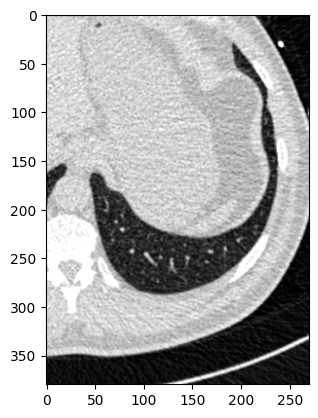

In [5]:
nisan = nib.load('/home/ORUNET/hanta231/2303_Chalmers/Data/BWT_Annotation_Summer2023/1/nifti/1020_bwt_L_93.nii').get_fdata()
plt.imshow(np.rot90(nisan[:,:,0]), cmap='gray')
print(nisan.shape[1])

320


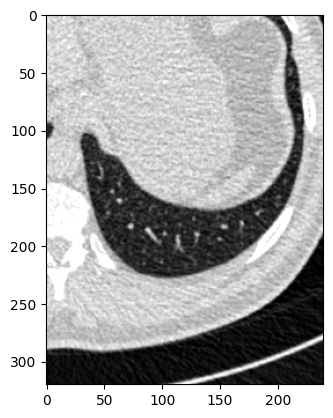

In [6]:
nisan = nib.load('/home/ORUNET/hanta231/2303_Chalmers/Data/BWT_Annotation_Summer2023_v1/1/nifti/1020_bwt_L_93.nii').get_fdata()
plt.imshow(np.rot90(nisan[:,:,0]), cmap='gray')
print(nisan.shape[1])

In [9]:
all_files = list(Path(v2_folder).glob('**/*.nii'))

In [11]:
def create_all_image_folder(sublist, dst_dir, makedirs = True):
    
    if makedirs:
        os.makedirs(dst_dir + "/all_nifti", exist_ok=True)

    for img_src in tqdm(sublist):

        dst = dst_dir + "/all_nifti/" + img_src.name
        shutil.copyfile(img_src, dst)

In [12]:
#create_all_image_folder(all_files, v2_folder, makedirs = True)

100%|██████████| 8184/8184 [15:17<00:00,  8.92it/s]
